<a href="https://colab.research.google.com/github/juan-holguin/TAM_2025_2/blob/main/Taller_parcial/Taller_parcial_juan_holguin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.datasets import fetch_california_housing

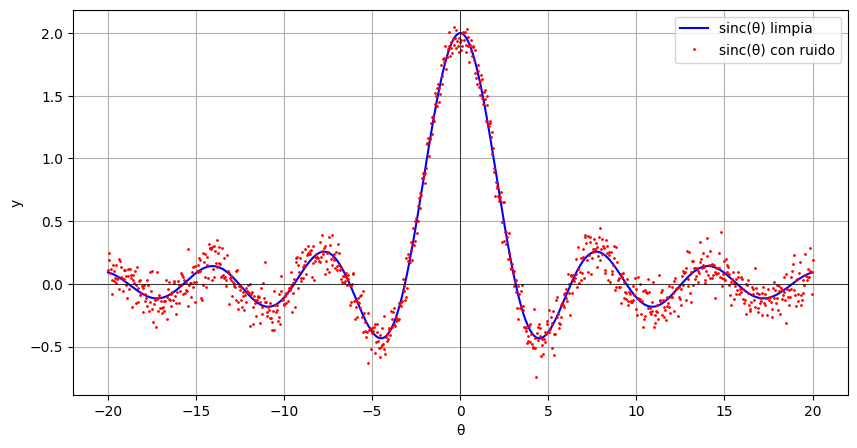

In [9]:
# Definición de sinc con amplitud A
def sinc(theta, A=1.0):
    return np.where(theta == 0, A, A * np.sin(theta)/theta)

# Parámetros
A = 2.0            # amplitud
sigma = 0.1        # desviación estándar del ruido
theta = np.linspace(-20, 20, 1000)

# Señal sinc pura
y_clean = sinc(theta, A)

# Señal con ruido gaussiano
noise = np.random.normal(0, sigma, size=theta.shape)
y_noisy = y_clean + noise

# Graficar
plt.figure(figsize=(10,5))
plt.plot(theta, y_clean, 'b', label="sinc(θ) limpia")
plt.plot(theta, y_noisy, 'r.', markersize=2, label="sinc(θ) con ruido")
plt.axhline(0, color='k', linewidth=0.5)
plt.axvline(0, color='k', linewidth=0.5)
plt.xlabel("θ")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()



In [10]:
# ============================
# PDF 2D (para prior/posterior)
# ============================
def my_2Dpdf(mu, Sigma, axes, cmap='Reds', xlim=[-3,3], ylim=[-3,3]):
    x = np.linspace(xlim[0], xlim[1], 100)
    y = np.linspace(ylim[0], ylim[1], 100)
    X, Y = np.meshgrid(x, y)
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X; pos[:, :, 1] = Y
    rv = multivariate_normal(mu, Sigma)
    Z = rv.pdf(pos)
    axes.contourf(X, Y, Z, cmap=cmap)
    axes.set_xlim(xlim); axes.set_ylim(ylim)

# ============================
# Muestreo de funciones lineales
# ============================
def my_linregsyn(mu, Sigma, axes, xlim=[-20,20], ylim=[-3,3], nsamples=5):
    X = np.linspace(xlim[0], xlim[1], 200)
    samples = np.random.multivariate_normal(mu, Sigma, nsamples)
    for w in samples:
        y = w[0] + w[1]*X
        axes.plot(X, y, 'b')
    axes.set_xlim(xlim); axes.set_ylim(ylim)

# ============================
# Posterior bayesiano (lineal)
# ============================
def my_posterior_update(X, t, sigma, sig_w, tol=1e-10):
    # X: entradas, t: salidas
    Phi = np.hstack([np.ones((X.shape[0],1)), X])   # diseño (bias + X)
    S0 = sig_w * np.eye(Phi.shape[1])
    Sn_inv = np.linalg.inv(S0) + (1/sigma**2) * Phi.T @ Phi
    Sn = np.linalg.inv(Sn_inv)
    mn = Sn @ ((1/sigma**2) * Phi.T @ t)
    return mn, Sn

# ============================
# Predictiva
# ============================
def my_predictiva_update(X, mN, SN, sigma):
    Phi = np.hstack([np.ones((X.shape[0],1)), X])
    mean = Phi @ mN
    var = np.sum(Phi @ SN * Phi, axis=1) + sigma**2
    return mean, np.sqrt(var)

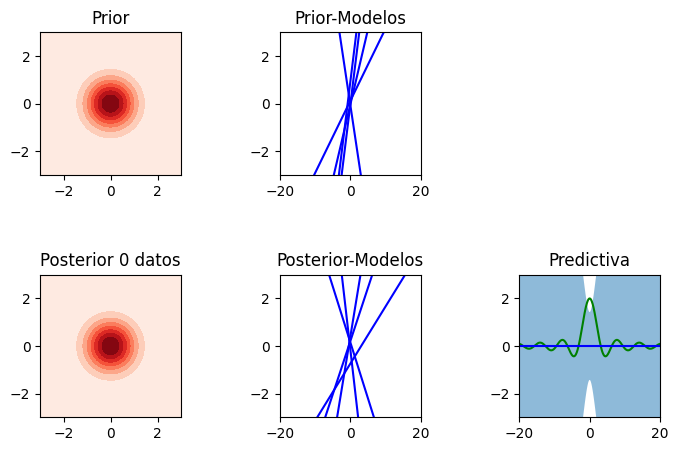

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

# ============================
# Definición de sinc con amplitud A
# ============================
def sinc(theta, A=1.0):
    return np.where(theta == 0, A, A * np.sin(theta)/theta)

# ============================
# Parámetros de la señal
# ============================
A = 2.0          # amplitud
sigma = 0.1      # desviación estándar del ruido
N = 500          # número de muestras

# ============================
# Variable de entrada (X = θ)
# ============================
theta = np.linspace(-20, 20, N).reshape(-1,1)

# Señal sinc limpia
tt = sinc(theta.ravel(), A)

# Señal observada con ruido
t = tt + np.random.normal(0, sigma, N)

# Formato correcto para la regresión Bayesiana
X = theta

# ============================
# Inicialización Bayesiana
# ============================
ind = np.random.randint(0, X.shape[0], size=X.shape[0])
mu_w = np.array([0,0])
sig_w = 0.5
S_w = sig_w*np.eye(len(mu_w))

# límites gráficos
wxlim = [-3,3]
wylim = [-3,3]
xlim = [-20,20]
ylim = [-3,3]

# ============================
# Funciones auxiliares (debes tenerlas definidas en tu notebook):
#   my_2Dpdf
#   my_linregsyn
#   my_posterior_update
#   my_predictiva_update
# ============================

# figura y axes animación
fig, ax = plt.subplots(2, 3, figsize=(8,5))
ax[0,2].axis('off')

# función de actualización para la animación
def update(i):
    ax[0,0].clear()
    ax[0,1].clear()
    ax[1,0].clear()
    ax[1,1].clear()
    ax[1,2].clear()

    # prior
    my_2Dpdf(mu_w, S_w, axes=ax[0,0], cmap='Reds', xlim=wxlim, ylim=wylim)
    my_linregsyn(mu_w, S_w, axes=ax[0,1], xlim=xlim, ylim=ylim)

    # posterior con i datos
    mN, SN = my_posterior_update(X[ind[:i]], t[ind[:i]], sigma, sig_w, tol=1e-10)
    my_2Dpdf(mN, SN, axes=ax[1,0], cmap='Reds', xlim=wxlim, ylim=wylim)
    my_linregsyn(mN, SN, axes=ax[1,1], xlim=xlim, ylim=ylim)
    ax[1,1].scatter(X[ind[:i],0], t[ind[:i]], c='r', marker='.')

    # graficar predictiva
    mnew, snew = my_predictiva_update(X, mN, SN, sigma)
    ax[1,2].plot(X[:,0], tt, c='g', label="sinc real")
    ax[1,2].scatter(X[ind[:i],0], t[ind[:i]], c='r', marker='.')
    ax[1,2].plot(X[:,0], mnew, c='b', label="predictiva")
    ii = np.argsort(X[:,0])
    ax[1,2].fill_between(X[ii,0].ravel(),
                         mnew[ii].ravel() - 2*snew[ii],
                         mnew[ii].ravel() + 2*snew[ii],
                         alpha=0.5)

    ax[1,2].set_xlim(xlim)
    ax[1,2].set_ylim(ylim)

    # títulos
    ax[0,0].set_title('Prior')
    ax[0,1].set_title('Prior-Modelos')
    ax[1,0].set_title('Posterior ' + str(i) + ' datos')
    ax[1,1].set_title('Posterior-Modelos')
    ax[1,2].set_title('Predictiva')
    plt.subplots_adjust(wspace=0.7, hspace=0.7)

# desplegar animación
anim = animation.FuncAnimation(
    fig, update, frames=np.array([0,1,2,3,5,7,9,10,15,20,25,50,100,250,499]),
    blit=False
)
rc('animation', html='jshtml')
HTML(anim.to_jshtml())

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
# División 70% train, 30% test
X_train, X_test, t_train, t_test = train_test_split(
    X, t, test_size=0.3, random_state=42
)

In [14]:
# Entrenamiento (posterior en train)
mN, SN = my_posterior_update(X_train, t_train, sigma, sig_w) # calcula la distribucion posterior

# Predictiva en train
m_train, s_train = my_predictiva_update(X_train, mN, SN, sigma) #calcula distribucion predictiva

# Predictiva en test
m_test, s_test = my_predictiva_update(X_test, mN, SN, sigma)#ahora usamos los datos de prueba

In [15]:
from sklearn.metrics import mean_squared_error

rmse_train = np.sqrt(mean_squared_error(t_train, m_train))
rmse_test = np.sqrt(mean_squared_error(t_test, m_test))

print(f"RMSE Train: {rmse_train:.4f}")
print(f"RMSE Test: {rmse_test:.4f}")

RMSE Train: 0.5564
RMSE Test: 0.5065


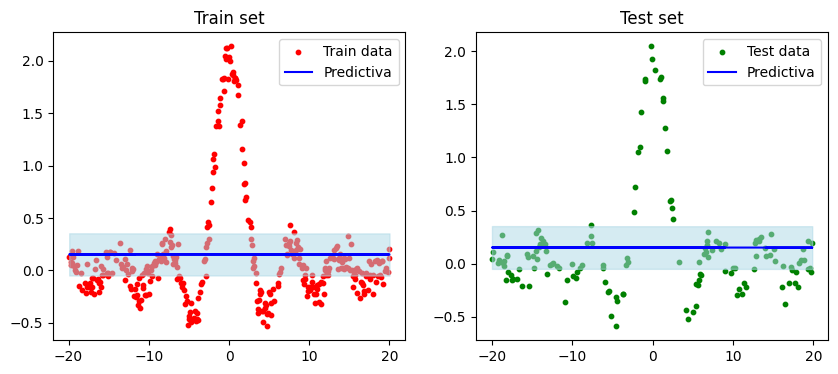

In [16]:
# Gráfico train
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.scatter(X_train, t_train, c="r", s=10, label="Train data")
plt.plot(X_train, m_train, "b", label="Predictiva")
ii = np.argsort(X_train[:,0])
plt.fill_between(X_train[ii,0].ravel(),
                 m_train[ii]-2*s_train[ii],
                 m_train[ii]+2*s_train[ii],
                 color="lightblue", alpha=0.5)
plt.title("Train set")
plt.legend()

# Gráfico test
plt.subplot(1,2,2)
plt.scatter(X_test, t_test, c="g", s=10, label="Test data")
plt.plot(X_test, m_test, "b", label="Predictiva")
ii = np.argsort(X_test[:,0])
plt.fill_between(X_test[ii,0].ravel(),
                 m_test[ii]-2*s_test[ii],
                 m_test[ii]+2*s_test[ii],
                 color="lightblue", alpha=0.5)
plt.title("Test set")
plt.legend()

plt.show()

# **Solucion por polinomios para la no linealidad**

In [17]:
!pip install scikit-optimize

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import StandardScaler,RobustScaler, PolynomialFeatures
from sklearn.linear_model import BayesianRidge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score,GridSearchCV
from skopt import BayesSearchCV

In [19]:
##FUNCIONES NECESARIAS##

# Generate sinc data (same as before)
def sinc(theta, A=1.0):
    return np.where(np.abs(theta) < 1e-12, A, A * np.sin(theta) / theta)

# Polynomial basis --> metodo manual
def design_matrix(X, degree):
    # X is (N,1) array of inputs
    N = X.shape[0]
    Phi = np.ones((N, degree+1))
    for d in range(1, degree+1):
        Phi[:, d] = (X.ravel()**d)
    return Phi

def posterior_update(Phi, t, sigma, S0):
    # returns posterior mean and covariance (mn, Sn)
    Sn_inv = np.linalg.inv(S0) + (1.0/sigma**2) * (Phi.T @ Phi)
    Sn = np.linalg.inv(Sn_inv)
    mn = Sn @ ((1.0/sigma**2) * (Phi.T @ t))
    return mn, Sn

def predictive(Phi, mn, Sn, sigma):
    mean = Phi @ mn
    var = np.sum((Phi @ Sn) * Phi, axis=1) + sigma**2
    return mean.ravel(), np.sqrt(var.ravel())



Polynomial degree = 20
RMSE Train: 0.0937
RMSE Test:  0.1075


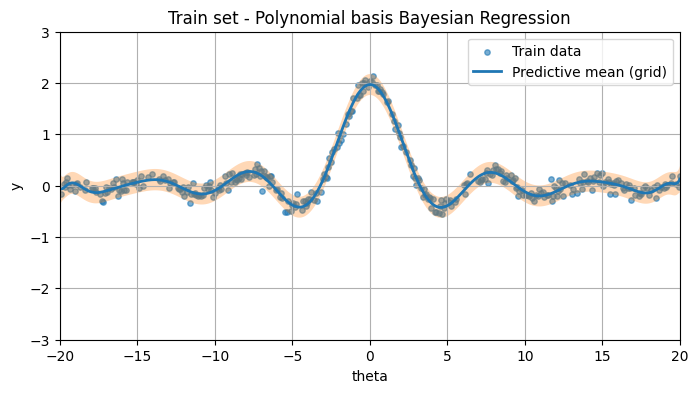

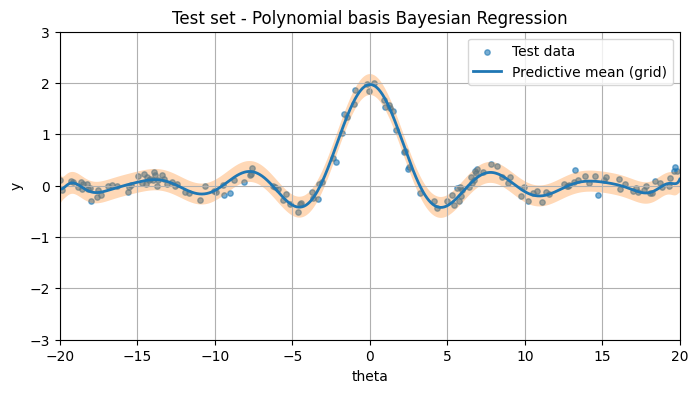

In [20]:
A = 2.0          # amplitud
sigma = 0.1      # ruido
N = 500          # muestras
theta = np.linspace(-20, 20, N).reshape(-1,1)
tt = sinc(theta.ravel()*1.0, A)   # true noiseless
t = tt + np.random.normal(0, sigma, N)  # observed noisy

degree = 20

# funcion para construir la matriz
#phiQ = PolynomialFeatures(degree=Q)
#Phi = phiQ.fit_transform(X)

Phi = design_matrix(theta, degree)

# Train/test split 70/30
X_train, X_test, t_train, t_test, Phi_train, Phi_test = train_test_split(
    theta, t, Phi, test_size=0.3, random_state=42
)


# Bayesian linear regression (closed form)
sig_w = 1.0  # prior variance for weights (can tune)
S0 = sig_w * np.eye(Phi_train.shape[1])

# Compute posterior using training data
mn, Sn = posterior_update(Phi_train, t_train, sigma, S0)

# Predictive on train and test
m_train, s_train = predictive(Phi_train, mn, Sn, sigma)
m_test, s_test = predictive(Phi_test, mn, Sn, sigma)

# RMSEs
rmse_train = np.sqrt(mean_squared_error(t_train, m_train))
rmse_test = np.sqrt(mean_squared_error(t_test, m_test))

print(f"Polynomial degree = {degree}")
print(f"RMSE Train: {rmse_train:.4f}")
print(f"RMSE Test:  {rmse_test:.4f}")

# Plotting: separate figures for train and test
# For smooth curve, evaluate predictive on fine grid
t_grid = np.linspace(-20, 20, 1000).reshape(-1,1)
Phi_grid = design_matrix(t_grid, degree)
m_grid, s_grid = predictive(Phi_grid, mn, Sn, sigma)

# Plot Train
plt.figure(figsize=(8,4))
plt.scatter(X_train, t_train, s=15, alpha=0.6, label='Train data')
plt.plot(t_grid, m_grid, linewidth=2, label='Predictive mean (grid)')
plt.fill_between(t_grid.ravel(), m_grid - 2*s_grid, m_grid + 2*s_grid, alpha=0.3)
plt.title("Train set - Polynomial basis Bayesian Regression")
plt.xlabel("theta")
plt.ylabel("y")
plt.legend()
plt.xlim([-20,20])
plt.ylim([-3,3])
plt.grid(True)

# Plot Test
plt.figure(figsize=(8,4))
plt.scatter(X_test, t_test, s=15, alpha=0.6, label='Test data')
plt.plot(t_grid, m_grid, linewidth=2, label='Predictive mean (grid)')
plt.fill_between(t_grid.ravel(), m_grid - 2*s_grid, m_grid + 2*s_grid, alpha=0.3)
plt.title("Test set - Polynomial basis Bayesian Regression")
plt.xlabel("theta")
plt.ylabel("y")
plt.legend()
plt.xlim([-20,20])
plt.ylim([-3,3])
plt.grid(True)

plt.show()


In [27]:
# Dataset California housing
data = fetch_california_housing()
X = data.data
y = data.target
feature_names = data.feature_names

# dividimos dataset
# 2. Dividir en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("Features:", feature_names)
print("X shape:", X.shape, "y shape:", y.shape)


Features: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
X shape: (20640, 8) y shape: (20640,)


MSE: 0.4517329640138344
R^2: 0.655833020778138


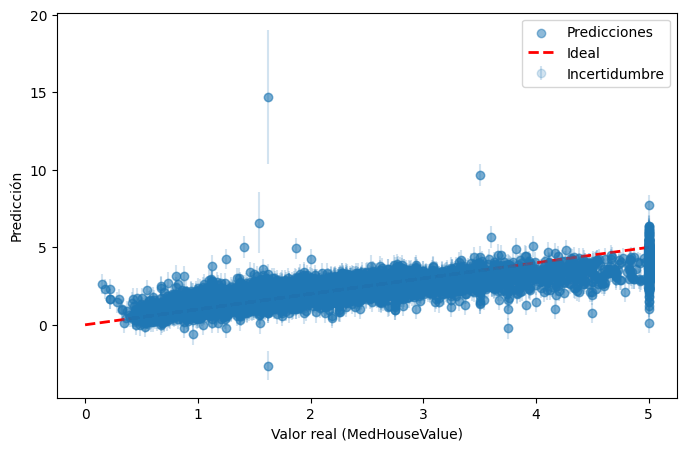

In [28]:
# 3/ Escalar con train
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4/ Expandir polinomios
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

# 5/ Ajustar modelo bayesiano
model = BayesianRidge() # calcula la distribución de probabilidades de los coeficientes
model.fit(X_train_poly, y_train)

# 6/ Predicciones con incertidumbre
y_pred, y_std = model.predict(X_test_poly, return_std=True)

# 7/ Evaluación
print("MSE:", mean_squared_error(y_test, y_pred))
print("R^2:", r2_score(y_test, y_pred))

# 8/ Visualizar
plt.figure(figsize=(8,5))
plt.scatter(y_test, y_pred, alpha=0.5, label="Predicciones")
plt.errorbar(y_test, y_pred, y_std, fmt='o', alpha=0.2, label="Incertidumbre")
plt.plot([0, 5], [0, 5], 'r--', lw=2, label="Ideal")
plt.xlabel("Valor real (MedHouseValue)")
plt.ylabel("Predicción")
plt.legend()
plt.show()


In [23]:
# Construir pipeline completo
pipeline = Pipeline([
    ("scaler", RobustScaler()),
    ("poly", PolynomialFeatures(degree=1, include_bias=False)),
    ("bayes", BayesianRidge())
])

# Validación cruzada (5 particiones)
scores = cross_val_score(pipeline, X, y, cv=8, scoring="r2")

print("R^2 promedio:", scores.mean())
print("R^2 por partición:", scores)


R^2 promedio: 0.548972965145752
R^2 por partición: [0.52064906 0.51762325 0.53800566 0.55365658 0.60020589 0.50154026
 0.44206684 0.71803619]


In [24]:
# buscamos con cual grado el R**2 es mejor

# Definir pipeline/ estructura del modelo
pipe = Pipeline([
    ("scaler", RobustScaler()),
    ("poly", PolynomialFeatures(include_bias=False)),
    ("model", BayesianRidge())
])

# Definir búsqueda de hiperparámetros
param_grid = {
    "poly__degree": [1, 2, 3, 4]  # grados polinómicos a probar
}

# GridSearchCV/ selecciona cual es el mejor grado a
grid = GridSearchCV(pipe, param_grid, cv=5, scoring="r2", n_jobs=-1)
grid.fit(X, y)

# Resultados
print("Mejor R^2 promedio:", grid.best_score_)
print("Mejor grado polinómico:", grid.best_params_)


Mejor R^2 promedio: 0.5530383571489347
Mejor grado polinómico: {'poly__degree': 1}


In [25]:
# Definir pipeline
pipe = Pipeline([
    ("scaler", RobustScaler()),
    ("poly", PolynomialFeatures(include_bias=False)),
    ("model", BayesianRidge())
])

# Definir búsqueda bayesiana
search_spaces = {
    "poly__degree": (1, 2),  # rango de grados polinómicos
    # también podrías incluir hiperparámetros de BayesianRidge:
    "model__alpha_1": (1e-6, 1, "log-uniform"),
    "model__alpha_2": (1e-6, 1, "log-uniform"),
    "model__lambda_1": (1e-6, 1e-3, "log-uniform"),
    "model__lambda_2": (1e-6, 1e-3, "log-uniform"),
}

opt = BayesSearchCV(
    pipe,
    search_spaces,
    n_iter=50,          # número de iteraciones (cuántas combinaciones probar)
    cv=5,
    scoring="r2",
    n_jobs=-1,
    random_state=42
)

opt.fit(X_train, y_train)
print("Mejor R^2 en validación cruzada:", opt.best_score_)
print("R^2 en test:", opt.score(X_test, y_test))


NameError: name 'y_train' is not defined

In [26]:
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

opt.fit(X_train, y_train_log)
print("R^2 en test (log):", r2_score(y_test_log, opt.predict(X_test)))

NameError: name 'y_train' is not defined